## ValidMind Initialization


In [76]:
import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "...",
  api_secret = "...",
  project = "..."
)

# Knockout Option pricing model

# model

In [79]:
import matplotlib.pyplot as plt
import numpy as np

class BlackScholesModel:
    def __init__(self, S0, K, T, r, sigma):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma

class StochasticVolatilityModel:
    def __init__(self, S0, K, T, r, v0, kappa, theta, xi, rho):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho


class KnockoutOption:
    def __init__(self, model, S0, K, T, r, barrier):
        self.model = model
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.barrier = barrier

    def price_knockout_option(self, N, M):
        dt = self.T / M
        price_paths = np.zeros((N, M + 1))
        vol_paths = np.zeros((N, M + 1)) if isinstance(self.model, StochasticVolatilityModel) else None
        price_paths[:, 0] = self.S0
        if vol_paths is not None:
            vol_paths[:, 0] = self.model.v0
        
        for t in range(1, M + 1):
            Z1 = np.random.standard_normal(N)
            if vol_paths is None:
                # Black-Scholes Model
                price_paths[:, t] = price_paths[:, t - 1] * np.exp(
                    (self.r - 0.5 * self.model.sigma**2) * dt + self.model.sigma * np.sqrt(dt) * Z1
                )
            else:
                # Stochastic Volatility Model
                Z2 = np.random.standard_normal(N)
                W1 = Z1
                W2 = self.model.rho * Z1 + np.sqrt(1 - self.model.rho**2) * Z2
                vol_paths[:, t] = np.abs(vol_paths[:, t - 1] + self.model.kappa * (self.model.theta - vol_paths[:, t - 1]) * dt + self.model.xi * np.sqrt(vol_paths[:, t - 1] * dt) * W1)
                price_paths[:, t] = price_paths[:, t - 1] * np.exp(
                    (self.r - 0.5 * vol_paths[:, t - 1]) * dt + np.sqrt(vol_paths[:, t - 1] * dt) * W2
                )
            
            # Knockout condition
            price_paths[:, t][price_paths[:, t] >= self.barrier] = 0
        payoffs = np.maximum(price_paths[:, -1] - self.K, 0)
        return np.exp(-self.r * self.T) * np.mean(payoffs)

## Sensitivity

In [82]:
def sensitivity_testing(model_type, S0, T, r, N, M, strike_range=None, barrier_range=None, sigma=0.2):
    """
    This is sensitivity test
    """
    if strike_range:
        strike_prices = np.linspace(strike_range[0], strike_range[1], 50)
        knockout_prices_strike = []

        for K in strike_prices:
            if model_type == 'BS':
                model = BlackScholesModel(S0, K, T, r, sigma)
            # else:
                # model = StochasticVolatilityModel(S0, K, T, r, model_params['v0'], model_params['kappa'], model_params['theta'], model_params['xi'], model_params['rho'])
            
            knockout_option = KnockoutOption(model, S0, K, T, r, barrier_range[0])
            price = knockout_option.price_knockout_option(N, M)
            knockout_prices_strike.append(price)
        
        fig1 = plt.figure(figsize=(10, 6))
        plt.plot(strike_prices, knockout_prices_strike, label='Knockout Option Price')
        plt.xlabel('Strike Price')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Strike Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    if barrier_range:
        barriers = np.linspace(barrier_range[0], barrier_range[1], 50)
        knockout_prices_barrier = []

        for barrier in barriers:
            if model_type == 'BS':
                model = BlackScholesModel(S0, strike_range[0], T, r, sigma)
            # else:
                # model = StochasticVolatilityModel(S0, strike_range[0], T, r, model_params['v0'], model_params['kappa'], model_params['theta'], model_params['xi'], model_params['rho'])
            
            knockout_option = KnockoutOption(model, S0, strike_range[0], T, r, barrier)
            price = knockout_option.price_knockout_option(N, M)
            knockout_prices_barrier.append(price)
        
        fig2 =  plt.figure(figsize=(10, 6))
        plt.plot(barriers, knockout_prices_barrier, label='Knockout Option Price')
        plt.xlabel('Barrier Level')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Barrier Level')
        plt.legend()
        plt.grid(True)
        plt.show()

    return fig1, fig2


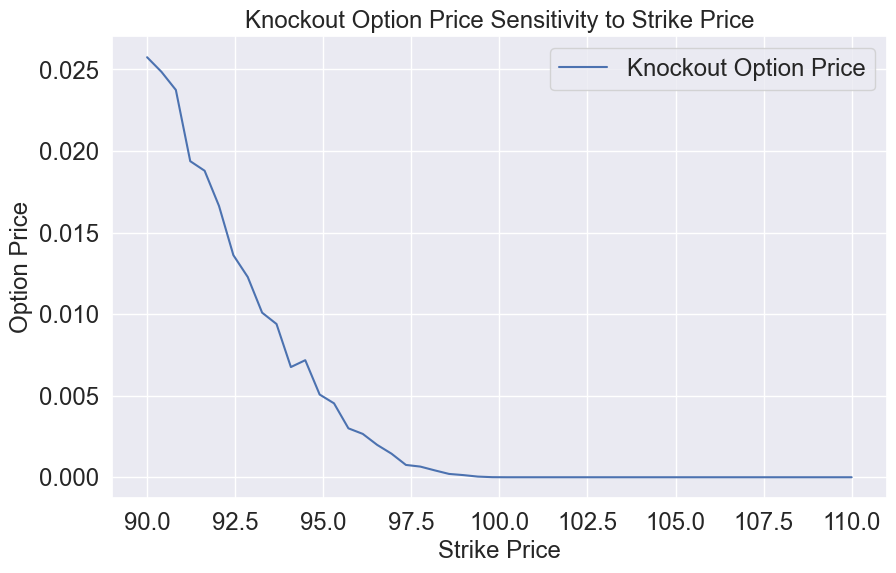

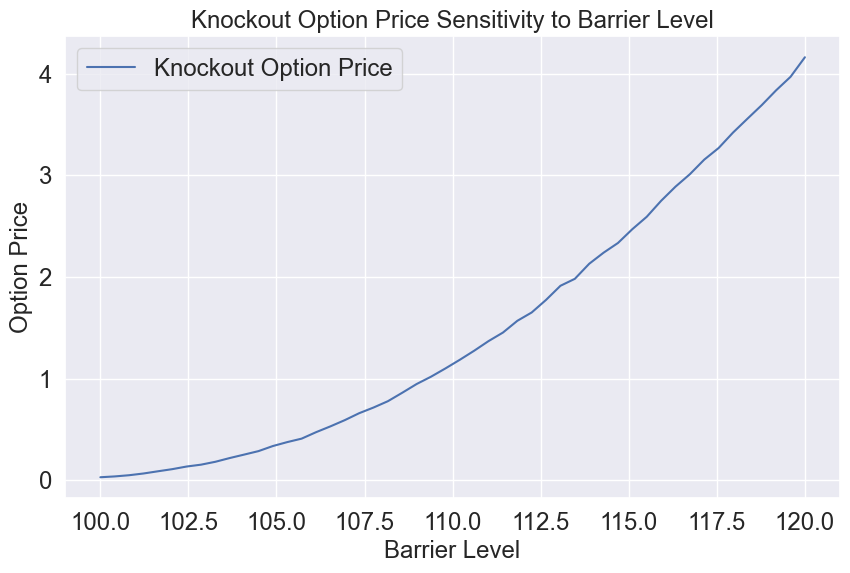

(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

In [83]:
# Example usage:
S0 = 100
T = 1
r = 0.05
N = 100000
M = 100
strike_range = (90, 110)
barrier_range = (100, 120)

# Black-Scholes Model Sensitivity Testing
sensitivity_testing('BS', S0, T, r, N, M, strike_range=strike_range, barrier_range=barrier_range, sigma=0.2)


## Move sensitivity into VM test 

In [56]:
import io
import matplotlib.pyplot as plt

@vm.test("my_custom_tests.SensitivityTesting")
def sensitivity_testing(model_type, S0, T, r, N, M, strike_range=None, barrier_range=None, sigma=0.2):
    """
    This is sensitivity test
    """
    if strike_range:
        strike_prices = np.linspace(strike_range[0], strike_range[1], 50)
        knockout_prices_strike = []

        for K in strike_prices:
            if model_type == 'BS':
                model = BlackScholesModel(S0, K, T, r, sigma)
            # else:
                # model = StochasticVolatilityModel(S0, K, T, r, model_params['v0'], model_params['kappa'], model_params['theta'], model_params['xi'], model_params['rho'])
            
            knockout_option = KnockoutOption(model, S0, K, T, r, barrier_range[0])
            price = knockout_option.price_knockout_option(N, M)
            knockout_prices_strike.append(price)
        
        fig1 = plt.figure(figsize=(10, 6))
        plt.plot(strike_prices, knockout_prices_strike, label='Knockout Option Price')
        plt.xlabel('Strike Price')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Strike Price')
        plt.legend()
        plt.grid(True)
        plt.close()  # close the plot to avoid displaying it

    if barrier_range:
        barriers = np.linspace(barrier_range[0], barrier_range[1], 50)
        knockout_prices_barrier = []

        for barrier in barriers:
            if model_type == 'BS':
                model = BlackScholesModel(S0, strike_range[0], T, r, sigma)
            # else:
                # model = StochasticVolatilityModel(S0, strike_range[0], T, r, model_params['v0'], model_params['kappa'], model_params['theta'], model_params['xi'], model_params['rho'])
            
            knockout_option = KnockoutOption(model, S0, strike_range[0], T, r, barrier)
            price = knockout_option.price_knockout_option(N, M)
            knockout_prices_barrier.append(price)
        
        fig2 =  plt.figure(figsize=(10, 6))
        plt.plot(barriers, knockout_prices_barrier, label='Knockout Option Price')
        plt.xlabel('Barrier Level')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Barrier Level')
        plt.legend()
        plt.grid(True)
        plt.close()  # close the plot to avoid displaying it

    return fig1, fig2


## Run test

In [84]:
from validmind.tests import run_test
# Example usage:
S0 = 100
T = 1
r = 0.05
N = 100000
M = 100
strike_range = (90, 110)
barrier_range = (100, 120)

result = run_test(
    "my_custom_tests.SensitivityTesting",
    params={
        "model_type": 'BS',
        "S0": S0,
        "T": T,
        "r": r,
        "N": N,
        "M": M,
        "strike_range": strike_range,
        "barrier_range": barrier_range,
        "sigma": 0.2
    },
)
result.log()

## version 2

In [23]:
@vm.test("my_custom_tests.SensitivityTesting_Strike")
def sensitivity_testing(model_type, S0, T, r, N, M, strike_range=None, barrier=None, model_params=None):
    """
    This is sensitivity test
    """
    if strike_range:
        strike_prices = np.linspace(strike_range[0], strike_range[1], 50)
        knockout_prices_strike = []

        for K in strike_prices:
            if model_type == 'BS':
                model = BlackScholesModel(model_params["S0"], K, model_params["T"], model_params["r"], model_params["sigma"])
            else:
                model = StochasticVolatilityModel(S0, K, T, r, model_params['v0'], model_params['kappa'], model_params['theta'], model_params['xi'], model_params['rho'])
            
            knockout_option = KnockoutOption(model, model_params["S0"], K, model_params["T"], model_params["r"], barrier_range[0])
            price = knockout_option.price_knockout_option(N, M)
            knockout_prices_strike.append(price)
        
        fig1 = plt.figure(figsize=(10, 6))
        plt.plot(strike_prices, knockout_prices_strike, label='Knockout Option Price')
        plt.xlabel('Strike Price')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Strike Price')
        plt.legend()
        plt.grid(True)
        plt.close()  # close the plot to avoid displaying it

    return fig1

In [ ]:
result = run_test(
    "my_custom_tests.SensitivityTesting_Strike",
    params={
        "model_type": 'BS',
        "N": N,
        "M": M,
        "strike_range": strike_range,
        "barrier": barrier_range[0],
        "model_params": {
            "S0": S0,
            "T": T,
            "r": r,
            "sigma": 0.2,
            "v0": 0.2,
            "kappa":2,
            "theta":0.2,
            "xi":0.1,
            "rho":-0.5,
        }
    },

)
result.log()

In [ ]:
result = run_test(
    "my_custom_tests.SensitivityTesting_Strike",
    params={
        "model_type": 'SV',
        "N": N,
        "M": M,
        "strike_range": strike_range,
        "barrier": barrier_range[0],
        "model_params": {
            "S0": S0,
            "T": T,
            "r": r,
            "sigma": 0.2,
            "v0": 0.2,
            "kappa":2,
            "theta":0.2,
            "xi":0.1,
            "rho":-0.5,
        }
    },
)
result.log()

## Version table

In [53]:
@vm.test("my_custom_tests.SensitivityTestingTable")
def sensitivity_testing(model_type, S0, T, r, N, M, strike=None, barrier=None, sigma=None, v0=None, kappa=None,theta=None, xi=None, rho=None):
    """
    This is sensitivity test
"""
    if model_type == 'BS':
        model = BlackScholesModel(S0, strike, T, r, sigma)
    else:
        model = StochasticVolatilityModel(S0, strike, T, r, v0, kappa, theta, xi, rho)
    
    knockout_option = KnockoutOption(model, S0, strike, T, r, barrier)
    price = knockout_option.price_knockout_option(N, M)

    return price

# Strike Sensitivity 

In [75]:
result = run_test(
    "my_custom_tests.SensitivityTestingTable:StrikeRange",
    param_grid={
        "model_type": ['SV'],
        "N": [N],
        "M": [M],
        "strike": list(np.linspace(strike_range[0], strike_range[1], 50)),
        "barrier": [barrier_range[0]],
        "S0": [S0],
        "T": [T],
        "r": [r],
        "sigma": [0.2],
        "v0": [0.2],
        "kappa": [2],
        "theta": [0.2],
        "xi": [0.1],
        "rho": [-0.5],
    },
)
result.log()

In [100]:
result = run_test(
    "my_custom_tests.SensitivityTestingTable:BarrierRange",
    param_grid={
        "model_type": ['BS'],
        "N": [N],
        "M": [M],
        "strike": [strike_range[0]],
        "barrier": list(np.linspace(barrier_range[0], barrier_range[1], 50)),
        "S0": [S0],
        "T": [T],
        "r": [r],
        "sigma": [0.2],
        "v0": [0.2],
        "kappa": [2],
        "theta": [0.2],
        "xi": [0.1],
        "rho": [-0.5],
    },
)
result.log()

In [104]:
def plot_results(df, params: dict = None):
        fig2 =  plt.figure(figsize=(10, 6))
        plt.plot(df[params["x"]], df[params["y"]], label='Knockout Option Price')
        plt.xlabel('Barrier Level')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Barrier Level')
        plt.legend()
        plt.grid(True)
        plt.show()  # close the plot to avoid displaying it


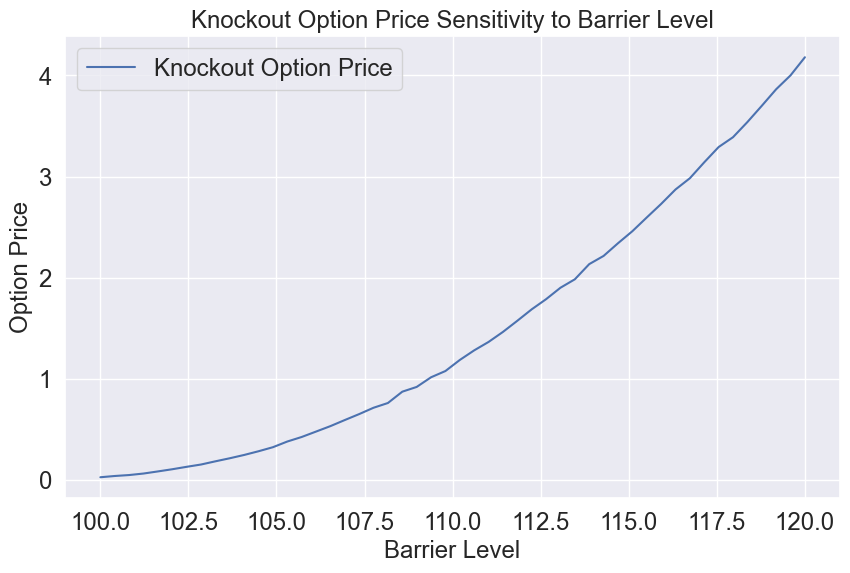

In [105]:
plot_results(pd.DataFrame(result.metric.summary.results[0].data), params={"x": "barrier","y":"value"})

In [87]:
import pandas as pd
pd.DataFrame(result.metric.summary.results[0].data)

,model_type,N,M,strike,barrier,S0,T,r,sigma,v0,kappa,theta,xi,rho,value
0,BS,100000,100,90,100.000000,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.0319
1,BS,100000,100,90,100.408163,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.0385
2,BS,100000,100,90,100.816327,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.0526
3,BS,100000,100,90,101.224490,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.0624
4,BS,100000,100,90,101.632653,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.0846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SV,100000,100,90,118.367347,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.6225
96,SV,100000,100,90,118.775510,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.6314
97,SV,100000,100,90,119.183673,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.6776
98,SV,100000,100,90,119.591837,100,1,0.05,0.2,0.2,2,0.2,0.1,-0.5,0.7266


In [ ]:
result = run_test(
    "my_custom_tests.SensitivityTestingTable:StrikeRange",
    param_grid={
        "model_type": ['SV'],
        "N": [N],
        "M": [M],
        "strike": [strike_range[0]],
        "barrier": [barrier_range[0]],
        "S0": [S0],
        "T": [T],
        "r": [r],
        "sigma": list(np.linspace(0.2, 0.99, 50)),
        "v0": [0.2],
        "kappa": [2],
        "theta": [0.2],
        "xi": [0.1],
        "rho": [-0.5],
    },
)
result.log()